Method described in Huning & AghaKouchak

In [1]:
import datetime
from datetime import date
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.integrate import trapz
from scipy.stats import norm
import seaborn as sns

Data paths

In [22]:
gap_filled_SWE = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/SWE_1979_2022_gapfilled_basin05BB001_Bow.nc'
CANSWE_v6 = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/CANSWE-CanEEN_1928-2023_v6.nc'

In [3]:
SWE = xr.open_dataset(gap_filled_SWE)

SWE_testbasin = SWE.to_dataframe()

display(SWE_testbasin)

SWE  flag donor_stations        lat         lon  \
time       station_id                                                           
1979-01-01 ALE-05BA811        NaN   NaN                 51.700001 -116.466667   
           SCD-AL003          NaN   NaN                 51.183334 -115.566666   
           ALE-05BA801        NaN   NaN                 51.416668 -116.183334   
           ALE-05BA802        NaN   NaN                 51.433334 -116.166664   
           ALE-05BA806        NaN   NaN                 51.416668 -116.233330   
...                           ...   ...            ...        ...         ...   
2022-07-31 ALE-05BA814        NaN   0.0                 51.683334 -116.383331   
           ALE-05BB803        NaN   0.0                 51.083332 -115.783333   
           ALE-05CA805        NaN   0.0                 51.533333 -116.050003   
           ALE-05BB803P  40.11483   0.0                 51.083332 -115.783333   
           ALE-05CA805P   3.89600   0.0                 51.540554 -116.056389   

                                    station_name  
time       station_id                             
1979-01-01 ALE-05BA811          BOW SUMMIT (OLD)  
           SCD-AL003                       BANFF  
           ALE-05BA801                 BOW RIVER  
           ALE-05BA802           PIPESTONE UPPER  
           ALE-05BA806               MIRROR LAKE  
...                                          ...  
2022-07-31 ALE-05BA814            KATHERINE LAKE  
           ALE-05BB803          SUNSHINE VILLAGE  
           ALE-05CA805            SKOKI MOUNTAIN  
           ALE-05BB803P  SUNSHINE VILLAGE PILLOW  
           ALE-05CA805P       SKOKI LODGE PILLOW  

[222852 rows x 6 columns]

In [23]:
SWE_v6 = xr.open_dataset(CANSWE_v6)

SWE_v6_data = SWE_v6.to_dataframe()

display(SWE_v6_data)

lat         lon  elevation               source  \
station_id  time                                                                
ALE-05AA805 1928-01-01  49.266666 -114.349998     1525.0  Alberta Environment   
            1928-01-02  49.266666 -114.349998     1525.0  Alberta Environment   
            1928-01-03  49.266666 -114.349998     1525.0  Alberta Environment   
            1928-01-04  49.266666 -114.349998     1525.0  Alberta Environment   
            1928-01-05  49.266666 -114.349998     1525.0  Alberta Environment   
...                           ...         ...        ...                  ...   
RTA-CQCS    2023-07-27  48.753777   71.831528      501.0      Rio Tinto Alcan   
            2023-07-28  48.753777   71.831528      501.0      Rio Tinto Alcan   
            2023-07-29  48.753777   71.831528      501.0      Rio Tinto Alcan   
            2023-07-30  48.753777   71.831528      501.0      Rio Tinto Alcan   
            2023-07-31  48.753777   71.831528      501.0      Rio Tinto Alcan   

                            station_name station_name_sec  station_name_ter  \
station_id  time                                                              
ALE-05AA805 1928-01-01  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN   
            1928-01-02  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN   
            1928-01-03  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN   
            1928-01-04  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN   
            1928-01-05  WEST CASTLE SNOW      WEST CASTLE  WEST CASTLE OPEN   
...                                  ...              ...               ...   
RTA-CQCS    2023-07-27      CHUTE SAVANE             None              None   
            2023-07-28      CHUTE SAVANE             None              None   
            2023-07-29      CHUTE SAVANE             None              None   
            2023-07-30      CHUTE SAVANE             None              None   
            2023-07-31      CHUTE SAVANE             None              None   

                       station_id_sec station_id_ter  type_mes   snw  snd  \
station_id  time                                                            
ALE-05AA805 1928-01-01      SCD-AL219      SCD-AL221         0   NaN  NaN   
            1928-01-02      SCD-AL219      SCD-AL221         0   NaN  NaN   
            1928-01-03      SCD-AL219      SCD-AL221         0   NaN  NaN   
            1928-01-04      SCD-AL219      SCD-AL221         0   NaN  NaN   
            1928-01-05      SCD-AL219      SCD-AL221         0   NaN  NaN   
...                               ...            ...       ...   ...  ...   
RTA-CQCS    2023-07-27           None           None         3  5.50  NaN   
            2023-07-28           None           None         3  4.50  NaN   
            2023-07-29           None           None         3  3.25  NaN   
            2023-07-30           None           None         3  2.50  NaN   
            2023-07-31           None           None         3  2.00  NaN   

                        den data_flag_snw data_flag_snd qc_flag_snw  \
station_id  time                                                      
ALE-05AA805 1928-01-01  NaN           b''           b''         b''   
            1928-01-02  NaN           b''           b''         b''   
            1928-01-03  NaN           b''           b''         b''   
            1928-01-04  NaN           b''           b''         b''   
            1928-01-05  NaN           b''           b''         b''   
...                     ...           ...           ...         ...   
RTA-CQCS    2023-07-27  NaN           b''          b'M'         b''   
            2023-07-28  NaN           b''          b'M'         b''   
            2023-07-29  NaN           b''          b'M'         b''   
            2023-07-30  NaN           b''          b'M'         b''   
            2023-07-31  NaN           b''          b'M'         b''   

                      

In [4]:
#Take mean SWE for each day for whole basin
daily_mean = SWE_testbasin.groupby('time')['SWE'].mean().reset_index()

# Rename the columns for clarity
daily_mean.columns = ['date', 'mean_SWE']

# Display the result
print(daily_mean)

            date    mean_SWE
0     1979-01-01  115.586667
1     1979-01-02  115.490000
2     1979-01-03  115.360000
3     1979-01-04  115.263333
4     1979-01-05  115.173333
...          ...         ...
15913 2022-07-27   21.446791
15914 2022-07-28   21.756103
15915 2022-07-29   22.024836
15916 2022-07-30   21.994835
15917 2022-07-31   22.005415

[15918 rows x 2 columns]


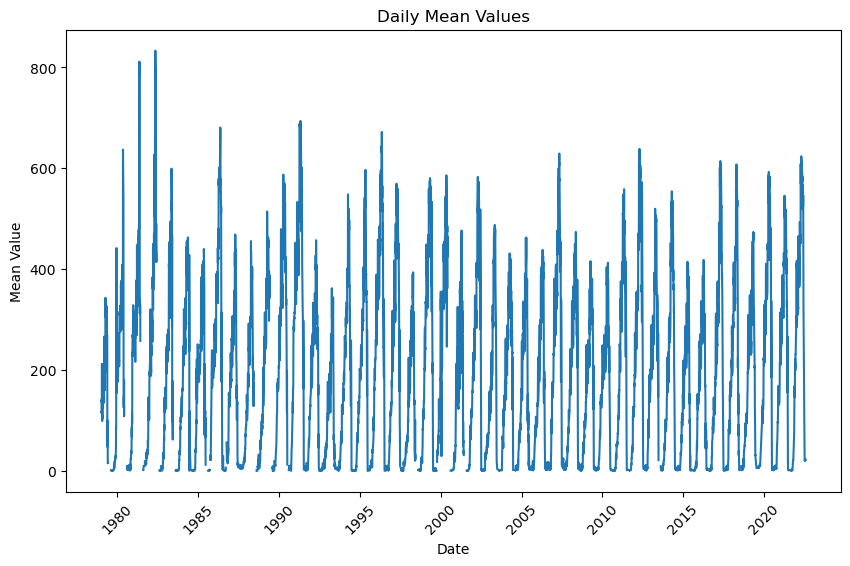

In [5]:
# Plot the daily mean values
plt.figure(figsize=(10,6))
plt.plot(daily_mean['date'], daily_mean['mean_SWE'])
plt.xlabel('Date')
plt.ylabel('Mean Value')
plt.title('Daily Mean Values')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Convert 'Date' to datetime
#daily_mean['date'] = pd.to_datetime(daily_mean['date'])

# Extract year and day of year from 'Date'
##daily_mean['Year'] = daily_mean['date'].dt.year
#daily_mean['DayOfYear'] = daily_mean['date'].dt.dayofyear

# Create the plot
#plt.figure(figsize=(10, 6))

# Group data by year and plot each year separately
#for year, data in daily_mean.groupby('Year'):
 ##   plt.plot(data['DayOfYear'], data['mean_SWE'], label=str(year))

# Add labels and title
#plt.xlabel('Day of Year')
#plt.ylabel('SWE (Snow Water Equivalent)')
#plt.title('Daily SWE from 1979 to 2022')
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
#plt.tight_layout()

# Show the plot
#plt.show()

In [7]:
# Set season parameters
start_month, start_day = 11, 1  # Start in November
end_month, end_day = 4, 30       # End in May

# Find the first date with 15 mm SWE each year to set as season start
daily_mean['season_year'] = daily_mean['date'].apply(lambda x: x.year if x.month >= start_month else x.year - 1)
season_starts = daily_mean[daily_mean['mean_SWE'] >= 15].groupby('season_year')['date'].min()

# Filter seasons based on season start and ensure they run through to April 1st of the next year
filtered_seasons = []

for year, start_date in season_starts.items():
    if start_date.month < start_month:
        continue  # Skip incomplete seasons at the beginning

    end_date = pd.Timestamp(year + 1, end_month, end_day)
    season_data = daily_mean[(daily_mean['date'] >= start_date) & (daily_mean['date'] <= end_date)]
    
    # Check if season has data from start_date to end_date (April 1st)
    if not season_data.empty and season_data['date'].max() >= end_date - pd.Timedelta(days=1):
        filtered_seasons.append(season_data)

# Combine all complete seasons
season_data = pd.concat(filtered_seasons, ignore_index=True)

# Extract the year and month-day for filtering
season_data['Year'] = season_data['date'].dt.year
season_data['Month-Day'] = season_data['date'].dt.strftime('%m-%d')
season_data['Year_Month'] = season_data['date'].dt.strftime('%Y-%m')

print(season_data.head(185))



          date    mean_SWE  season_year  Year Month-Day Year_Month
0   1979-11-01   18.325000         1979  1979     11-01    1979-11
1   1979-11-02   17.760000         1979  1979     11-02    1979-11
2   1979-11-03   17.890000         1979  1979     11-03    1979-11
3   1979-11-04   17.685000         1979  1979     11-04    1979-11
4   1979-11-05   17.510000         1979  1979     11-05    1979-11
..         ...         ...          ...   ...       ...        ...
180 1980-04-29  409.423750         1979  1980     04-29    1980-04
181 1980-04-30  381.655556         1979  1980     04-30    1980-04
182 1980-11-01   23.605000         1980  1980     11-01    1980-11
183 1980-11-02   23.930000         1980  1980     11-02    1980-11
184 1980-11-03   24.100000         1980  1980     11-03    1980-11

[185 rows x 6 columns]


# Step 1: Replace zeros with perturbations

In [9]:

def perturb_zeros(swe_column):
    """Perturbs zero values with small positive values."""
    swe_array = swe_column.to_numpy()  # Convert to NumPy array for efficient manipulation
    nonzero_min = swe_array[swe_array > 0].min()  # Find the smallest nonzero value
    
    # Generate perturbations for zero values
    perturbation = np.random.uniform(0, nonzero_min / 2, size=swe_column[swe_column == 0].shape)
    
    # Replace zeros with perturbation
    swe_column[swe_column == 0] = perturbation
    
    return swe_column

# Apply to mean_SWE column only
season_data['mean_SWE'] = perturb_zeros(season_data['mean_SWE'].copy())

print(season_data.head(185))
print("Number of zeros in mean_SWE:", (season_data['mean_SWE'] == 0).sum())

#season_data.to_csv('C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/season_data.csv')

          date    mean_SWE  season_year  Year Month-Day Year_Month
0   1979-11-01   18.325000         1979  1979     11-01    1979-11
1   1979-11-02   17.760000         1979  1979     11-02    1979-11
2   1979-11-03   17.890000         1979  1979     11-03    1979-11
3   1979-11-04   17.685000         1979  1979     11-04    1979-11
4   1979-11-05   17.510000         1979  1979     11-05    1979-11
..         ...         ...          ...   ...       ...        ...
180 1980-04-29  409.423750         1979  1980     04-29    1980-04
181 1980-04-30  381.655556         1979  1980     04-30    1980-04
182 1980-11-01   23.605000         1980  1980     11-01    1980-11
183 1980-11-02   23.930000         1980  1980     11-02    1980-11
184 1980-11-03   24.100000         1980  1980     11-03    1980-11

[185 rows x 6 columns]
Number of zeros in mean_SWE: 0


# Step 2: Compute 6-month SWE integration 

In [10]:
# Step 1: Filter for November to May
#df_seasonal = season_data[season_data['Month-Day'].between('11-01', '04-30')]
def integrate_season(group):
    """Integrates SWE values from November 1st to May 1st."""
    # Ensure dates are sorted (though dataset is pre-sorted)
    group = group.sort_values(by='date')
    # Convert dates to numerical days since start of the season
    days_since_start = (group['date'] - group['date'].min()).dt.days
    # Integrate SWE over the period
    total_swe_integration = trapz(group['mean_SWE'], days_since_start)
    return pd.Series({'total_SWE_integration': total_swe_integration})


# Group by season_year and compute integration
Integrated_data = season_data.groupby('season_year').apply(integrate_season).reset_index()

# Inspect results
print(Integrated_data.head())
print(season_data.head())

   season_year  total_SWE_integration
0         1979           42850.272430
1         1980           47112.735200
2         1981           45146.120786
3         1982           40939.580803
4         1983           38208.476211
        date  mean_SWE  season_year  Year Month-Day Year_Month
0 1979-11-01    18.325         1979  1979     11-01    1979-11
1 1979-11-02    17.760         1979  1979     11-02    1979-11
2 1979-11-03    17.890         1979  1979     11-03    1979-11
3 1979-11-04    17.685         1979  1979     11-04    1979-11
4 1979-11-05    17.510         1979  1979     11-05    1979-11


In [11]:
# Group by month and compute integration
Integrated_data_monthly = season_data.groupby('Year_Month').apply(integrate_season).reset_index()

# Ensure season_year corresponds to each month
Integrated_data_monthly['season_year'] = Integrated_data_monthly['Year_Month'].apply(lambda x: int(x.split('-')[0]) if int(x.split('-')[1]) >= start_month else int(x.split('-')[0]) - 1)

# Group by season_year and compute integration
Integrated_data_season = Integrated_data_monthly.groupby('season_year').sum().reset_index()

print(Integrated_data_season.head(10))
print(Integrated_data_monthly.head(10))
Integrated_data_season.to_csv('C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/output_data/Integrated_data_season.csv')

   season_year  total_SWE_integration
0         1979           41633.608176
1         1980           45817.338437
2         1981           43960.849632
3         1982           39900.253322
4         1983           37181.337794
5         1984           38415.954817
6         1985           55556.983959
7         1986           40032.263184
8         1987           32007.801006
9         1988           37739.950088
  Year_Month  total_SWE_integration  season_year
0    1979-11             682.297000         1979
1    1979-12            7109.898750         1979
2    1980-01            6747.594139         1979
3    1980-02            7419.457376         1979
4    1980-03            9720.528594         1979
5    1980-04            9953.832317         1979
6    1980-11            1506.384167         1980
7    1980-12            7714.283750         1980
8    1981-01            7783.131251         1980
9    1981-02            7640.548704         1980


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_15944\4002902403.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Integrated_data_season = Integrated_data_monthly.groupby('season_year').sum().reset_index()


# Step 3: Rank data and compute Gringorten probabilities

In [12]:
def gringorten_probabilities(values):
    """Compute Gringorten plotting position probabilities."""
    sorted_values = np.sort(values)
    ranks = np.argsort(np.argsort(values)) + 1  # Rank from smallest to largest
    n = len(values)
    probabilities = (ranks - 0.44) / (n + 0.12)
    return probabilities

# Ensure you're applying the function only to 'total_SWE_integration'
if 'total_SWE_integration' in Integrated_data_season.columns:
    Integrated_data_season['Gringorten_probabilities'] = gringorten_probabilities(Integrated_data_season['total_SWE_integration'])
else:
    print("Error: 'total_SWE_integration' column is missing.")

# Inspect results
print(Integrated_data_season.head())

   season_year  total_SWE_integration  Gringorten_probabilities
0         1979           41633.608176                  0.500000
1         1980           45817.338437                  0.639147
2         1981           43960.849632                  0.592764
3         1982           39900.253322                  0.360853
4         1983           37181.337794                  0.198516


# Step 4: Compute SWEI

In [14]:
def compute_swei(probabilities):
    """Transform probabilities to SWEI using the inverse normal distribution."""
    return norm.ppf(probabilities)

# Ensure 'Gringorten_probabilities' exists before computing SWEI
if 'Gringorten_probabilities' in Integrated_data_season.columns:
    Integrated_data_season['SWEI'] = compute_swei(Integrated_data_season['Gringorten_probabilities'])

# Step 5: Classify drought conditions
def classify_drought(swei):
    """Classify drought conditions based on SWEI values."""
    if swei <= -2.0:
        return "Exceptional Drought"
    elif -2.0 < swei <= -1.5:
        return "Extreme Drought"
    elif -1.5 < swei <= -1.0:
        return "Severe Drought"
    elif -1.0 < swei <= -0.5:
        return "Moderate Drought"
    elif -0.5 < swei <= 0.5:
        return "Near Normal"
    elif 0.5 < swei <= 1.0:
        return "Abnormally Wet"
    elif 1.0 < swei <= 1.5:
        return "Moderately Wet"
    elif 1.5 < swei <= 2.0:
        return "Very Wet"
    else:
        return "Extremely Wet"


# Apply drought classification to the SWEI column
if 'SWEI' in Integrated_data_season.columns:
    Integrated_data_season['Drought_Classification'] = Integrated_data_season['SWEI'].apply(classify_drought)

# Step 3: Select relevant columns for output
if 'season_year' in Integrated_data_season.columns:
    output_columns = ['season_year', 'Gringorten_probabilities', 'SWEI', 'Drought_Classification']
elif 'year' in Integrated_data_season.columns:
    output_columns = ['year', 'Gringorten_probabilities', 'SWEI', 'Drought_Classification']
else:
    output_columns = ['Gringorten_probabilities', 'SWEI', 'Drought_Classification']

# Output the SWEI and drought classifications
#print("Standardized SWEI:\n", Integrated_data[['Gringorten_probabilities', 'SWEI']].head())
#print("\nDrought Classifications:\n", Integrated_data[['SWEI', 'Drought_Classification']])

# Output the selected columns
print("Results:\n", Integrated_data_season[output_columns])

Results:
     season_year  Gringorten_probabilities      SWEI Drought_Classification
0          1979                  0.500000  0.000000            Near Normal
1          1980                  0.639147  0.356179            Near Normal
2          1981                  0.592764  0.234662            Near Normal
3          1982                  0.360853 -0.356179            Near Normal
4          1983                  0.198516 -0.846935       Moderate Drought
5          1984                  0.268089 -0.618603       Moderate Drought
6          1985                  0.917440  1.388054         Moderately Wet
7          1986                  0.384045 -0.294875            Near Normal
8          1987                  0.082560 -1.388054         Severe Drought
9          1988                  0.221707 -0.766441       Moderate Drought
10         1989                  0.871058  1.131404         Moderately Wet
11         1990                  0.987013  2.226600          Extremely Wet
12         1991

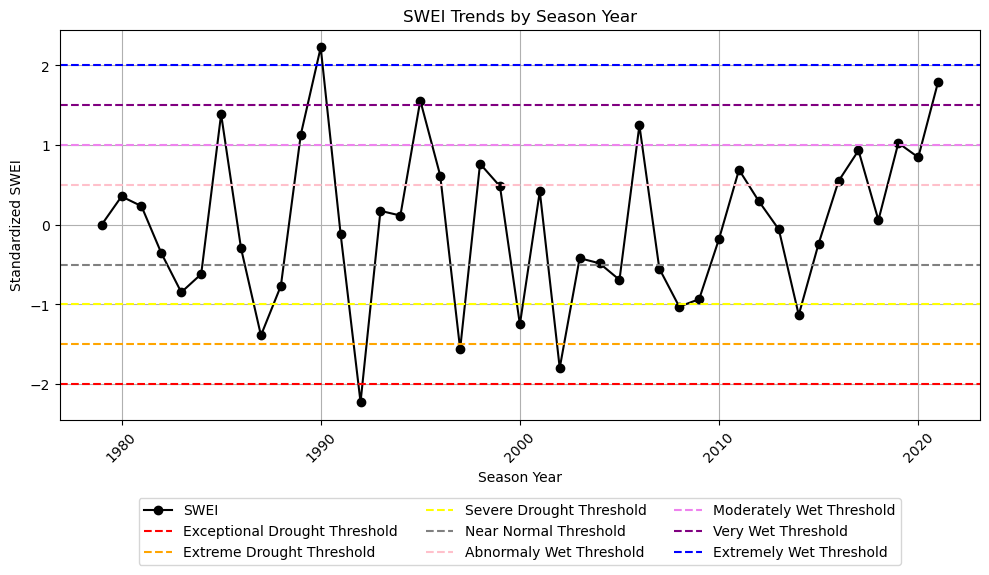

In [ ]:
# Extract necessary columns
plot_data = Integrated_data_season[['season_year', 'SWEI', 'Drought_Classification']]

# Sort by season_year for better plotting
plot_data = plot_data.sort_values(by='season_year')
plt.figure(figsize=(10, 6))
plt.plot(plot_data['season_year'], plot_data['SWEI'], marker='o', label='SWEI', color='black')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# Customize the plot
plt.title('SWEI Trends by Season Year')
plt.xlabel('Season Year')
plt.ylabel('Standardized SWEI')
plt.xticks(rotation=45)
plt.legend(
    loc='upper center',               # Center the legend at the bottom
    bbox_to_anchor=(0.5, -0.2),      # Adjust the position (0.5 is horizontal center, -0.15 is below the plot)
    ncol=3,                           # Show 3 items per row
    borderaxespad=0.,                 # Reduce padding
    frameon=True                      # Add a box around the legend (optional)
)
plt.grid()
plt.tight_layout()
plt.show()